<a href="https://colab.research.google.com/github/sjunc/2025-1-BigData-Team/blob/main/analysis/%EB%B0%95%EC%84%B1%EC%A4%80_%EB%B2%94%EC%A3%84%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 한글 폰트(오류 방지)
# 현재 셀을 실행한 후 세션 다시 시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
# PC에서 한글 설정
plt.rc('font', family='NanumBarunGothic') # 설치한 폰트
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# PC에서 그림 설정
plt.rcParams.update({'figure.dpi': '100'})
plt.rcParams.update({'figure.figsize': [6, 4]})

In [5]:
# 그림 선명하게
%config InlineBackend.figure_format = 'retina'

In [6]:
!git clone https://github.com/sjunc/2025-1-BigData-Team

Cloning into '2025-1-BigData-Team'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 215 (delta 20), reused 0 (delta 0), pack-reused 174 (from 1)
Receiving objects: 100% (215/215), 6.75 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (84/84), done.


## 범죄 발생 지역 분석(2023년)

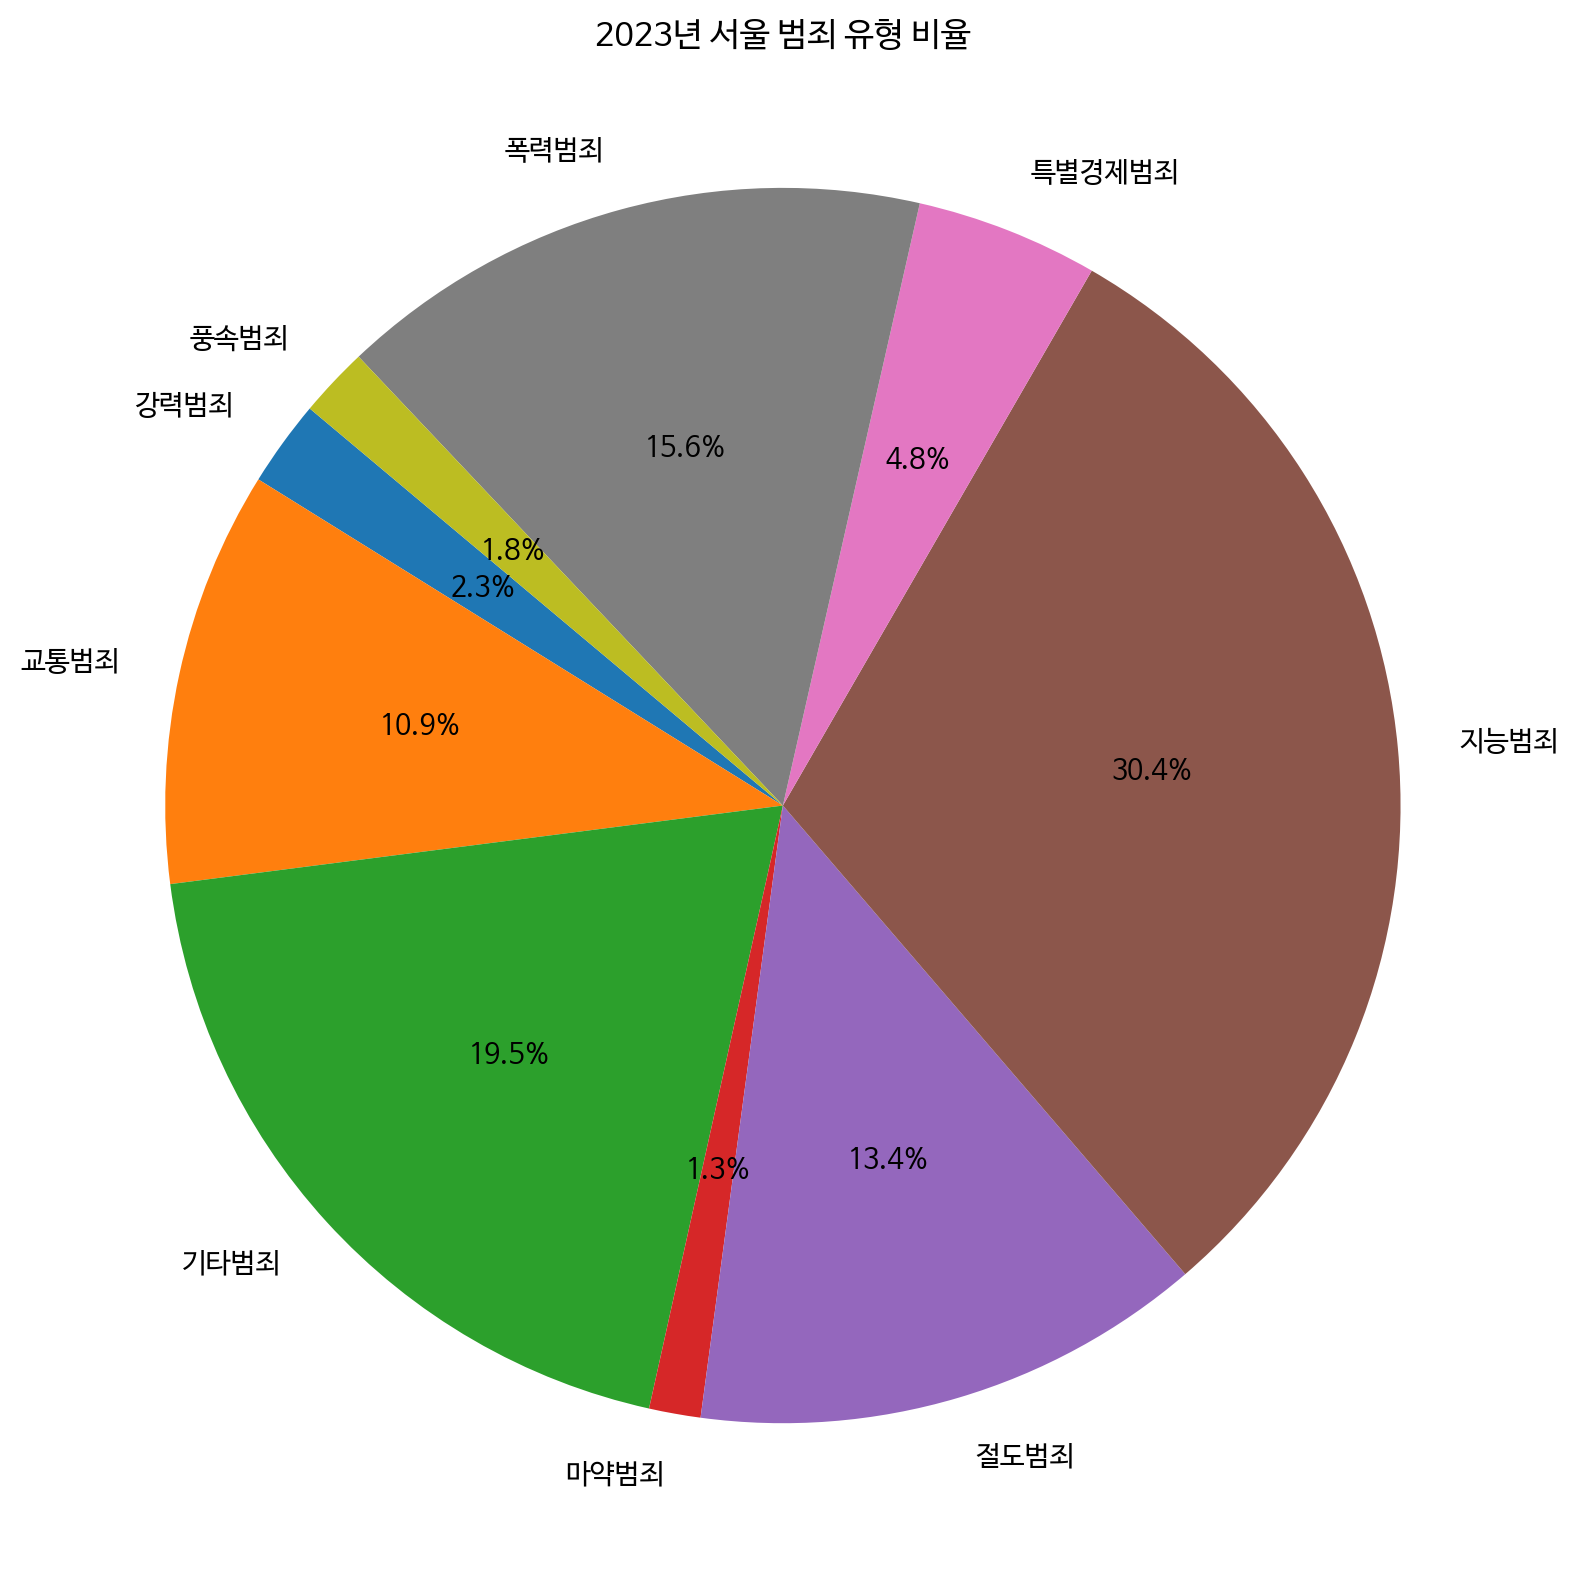

In [7]:
file_path = './2025-1-BigData-Team/CrimeData/범죄발생지역(2012~2023)/경찰청_범죄발생지_2023.csv'
df = pd.read_csv(file_path, encoding='cp949')

# 서울 열만 골라서 합산
seoul_cols = [col for col in df.columns if col.startswith('서울')]
df['서울합계'] = df[seoul_cols].sum(axis=1)

# 범죄 대분류 기준 발생 건수 합산
summary = df.groupby('범죄대분류')['서울합계'].sum()

# 1.2% 미만 항목 기타범죄에 합산
total = summary.sum()
threshold = total * 0.012
low_ratio_idx = summary[summary < threshold].index
summary.loc['기타범죄'] += summary[low_ratio_idx].sum()
summary = summary.drop(index=low_ratio_idx)

# 그래프
plt.figure(figsize=(8, 8))
plt.pie(summary, labels=summary.index, autopct='%1.1f%%', startangle=140)
plt.title('2023년 서울 범죄 유형 비율')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [8]:
# 서울은 지능범죄에 비율이 30.4%로 가장 높음.
# 지역에 상관없이 지능범죄에 비율이 높은 지 확인 필요.

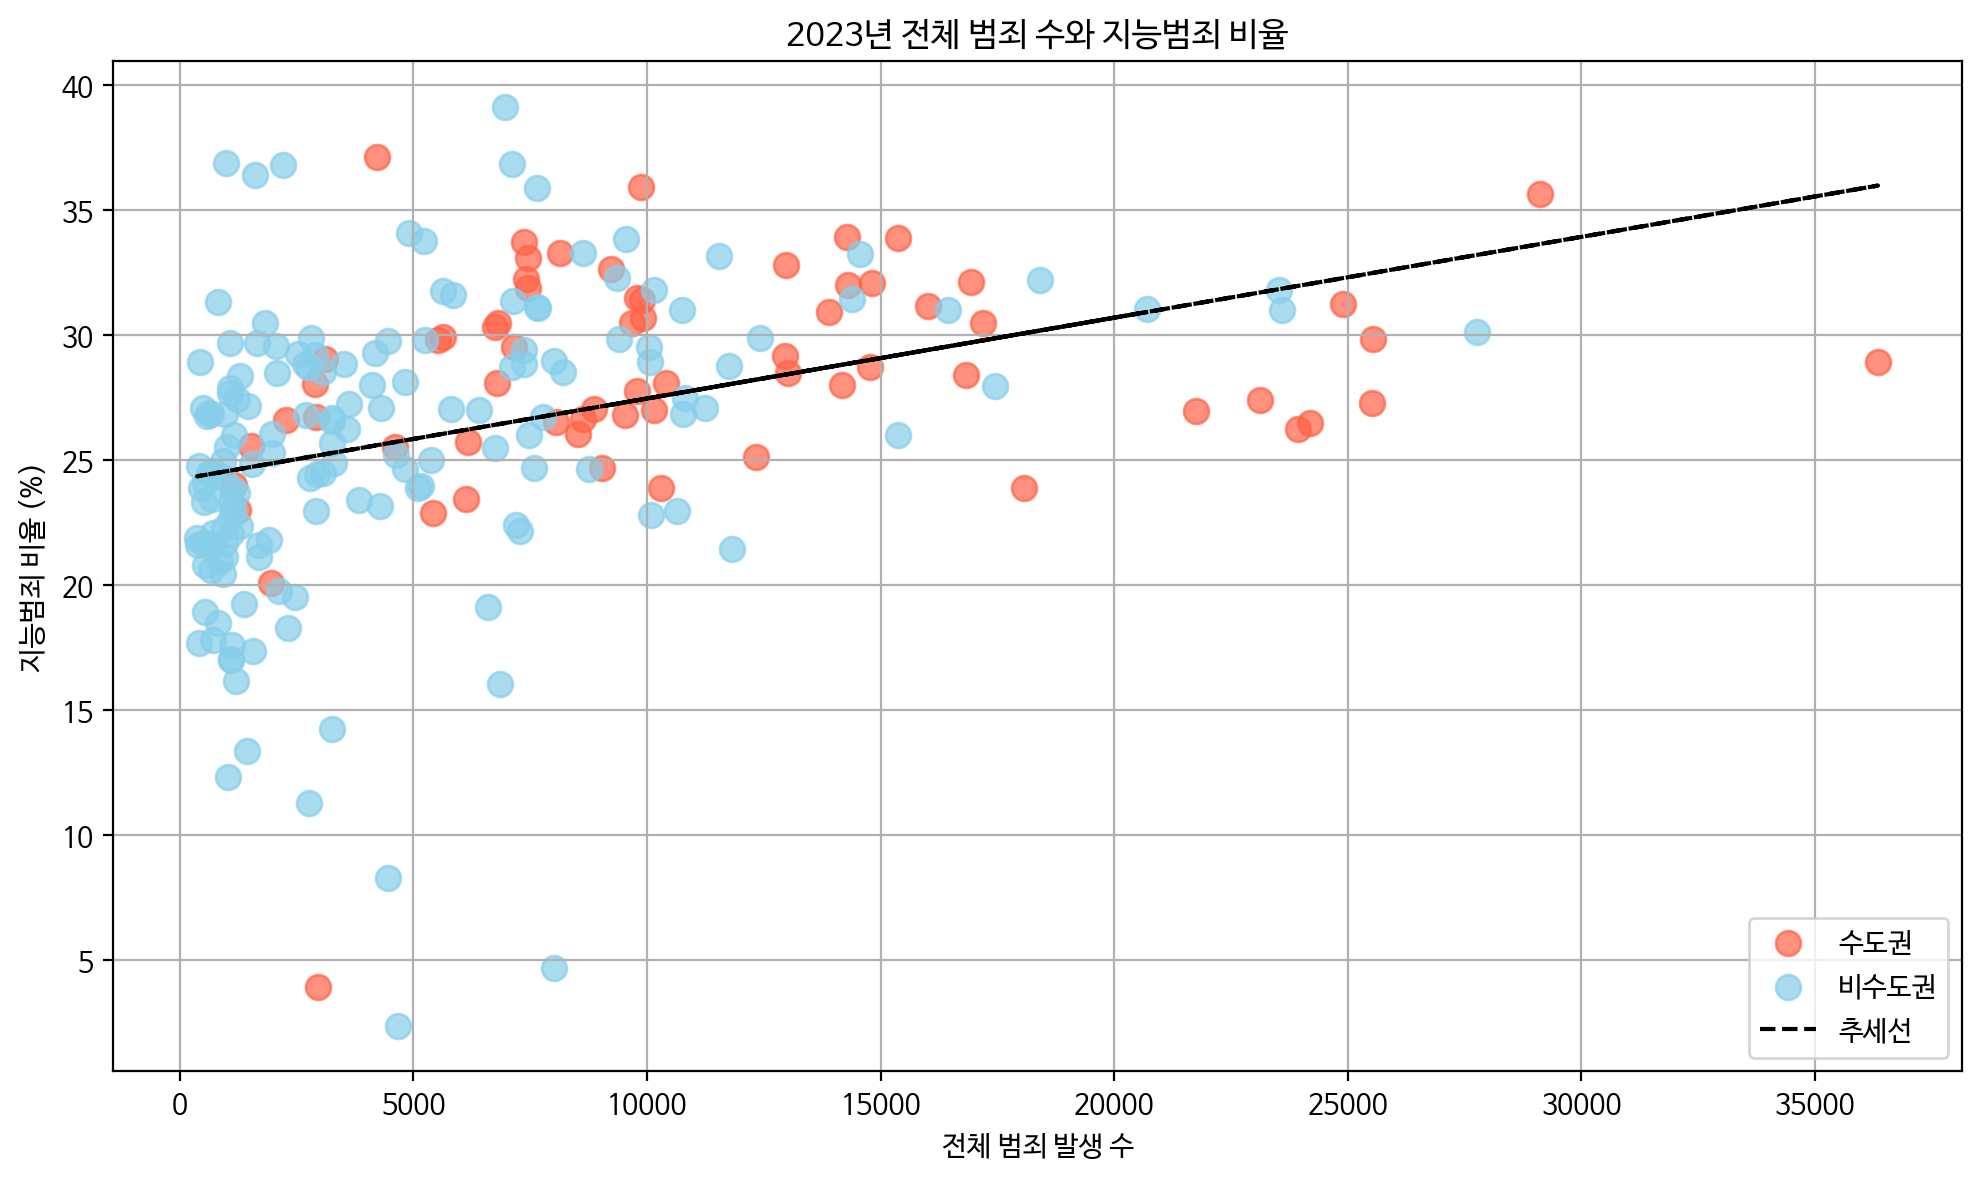

In [9]:
file_path = './2025-1-BigData-Team/CrimeData/범죄발생지역(2012~2023)/경찰청_범죄발생지_2023.csv'
df = pd.read_csv(file_path, encoding='cp949')

# 칼럼 추출
region_cols = df.columns[2:-1]

# 전체 범죄 수
total_by_region = df[region_cols].sum()

# 지능범죄 필터링 후 합산
intel_df = df[df['범죄대분류'] == '지능범죄']
intel_by_region = intel_df[region_cols].sum()

# 비율 계산 (%)
intel_ratio = (intel_by_region / total_by_region * 100).round(2)

# 데이터프레임 정리
scatter_df = pd.DataFrame({
    '시도': intel_ratio.index,
    '전체범죄수': total_by_region.values,
    '지능범죄비율': intel_ratio.values
})

# 수도권 구분 추가
capital_area = ['서울', '경기', '인천']
scatter_df['구분'] = scatter_df['시도'].apply(lambda x: '수도권' if any(cap in x for cap in capital_area) else '비수도권')

# 이상치 제거
threshold = scatter_df['전체범죄수'].quantile(0.08)
scatter_df = scatter_df[scatter_df['전체범죄수'] > threshold]

# 시각화
colors = {'수도권': 'tomato', '비수도권': 'skyblue'}
plt.figure(figsize=(10, 6))
for gubun in scatter_df['구분'].unique():
    sub_df = scatter_df[scatter_df['구분'] == gubun]
    plt.scatter(sub_df['전체범죄수'], sub_df['지능범죄비율'],
                label=gubun, color=colors[gubun], alpha=0.7, s=80)

# 회귀선 추가
z = np.polyfit(scatter_df['전체범죄수'], scatter_df['지능범죄비율'], 1)
p = np.poly1d(z)
plt.plot(scatter_df['전체범죄수'], p(scatter_df['전체범죄수']), "k--", label='추세선')

# 그래프
plt.xlabel('전체 범죄 발생 수')
plt.ylabel('지능범죄 비율 (%)')
plt.title('2023년 전체 범죄 수와 지능범죄 비율')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# 지역에 상관없이 지능범죄에 비율이 20% ~ 30%가 대다수.
# 전체 범죄 발생 수가 높을수록 지능범죄에 비율이 높아지는 추세.
# 대체로 수도권이 범죄 발생 수도 많으며 지능범죄 비율이 낮지 않음.

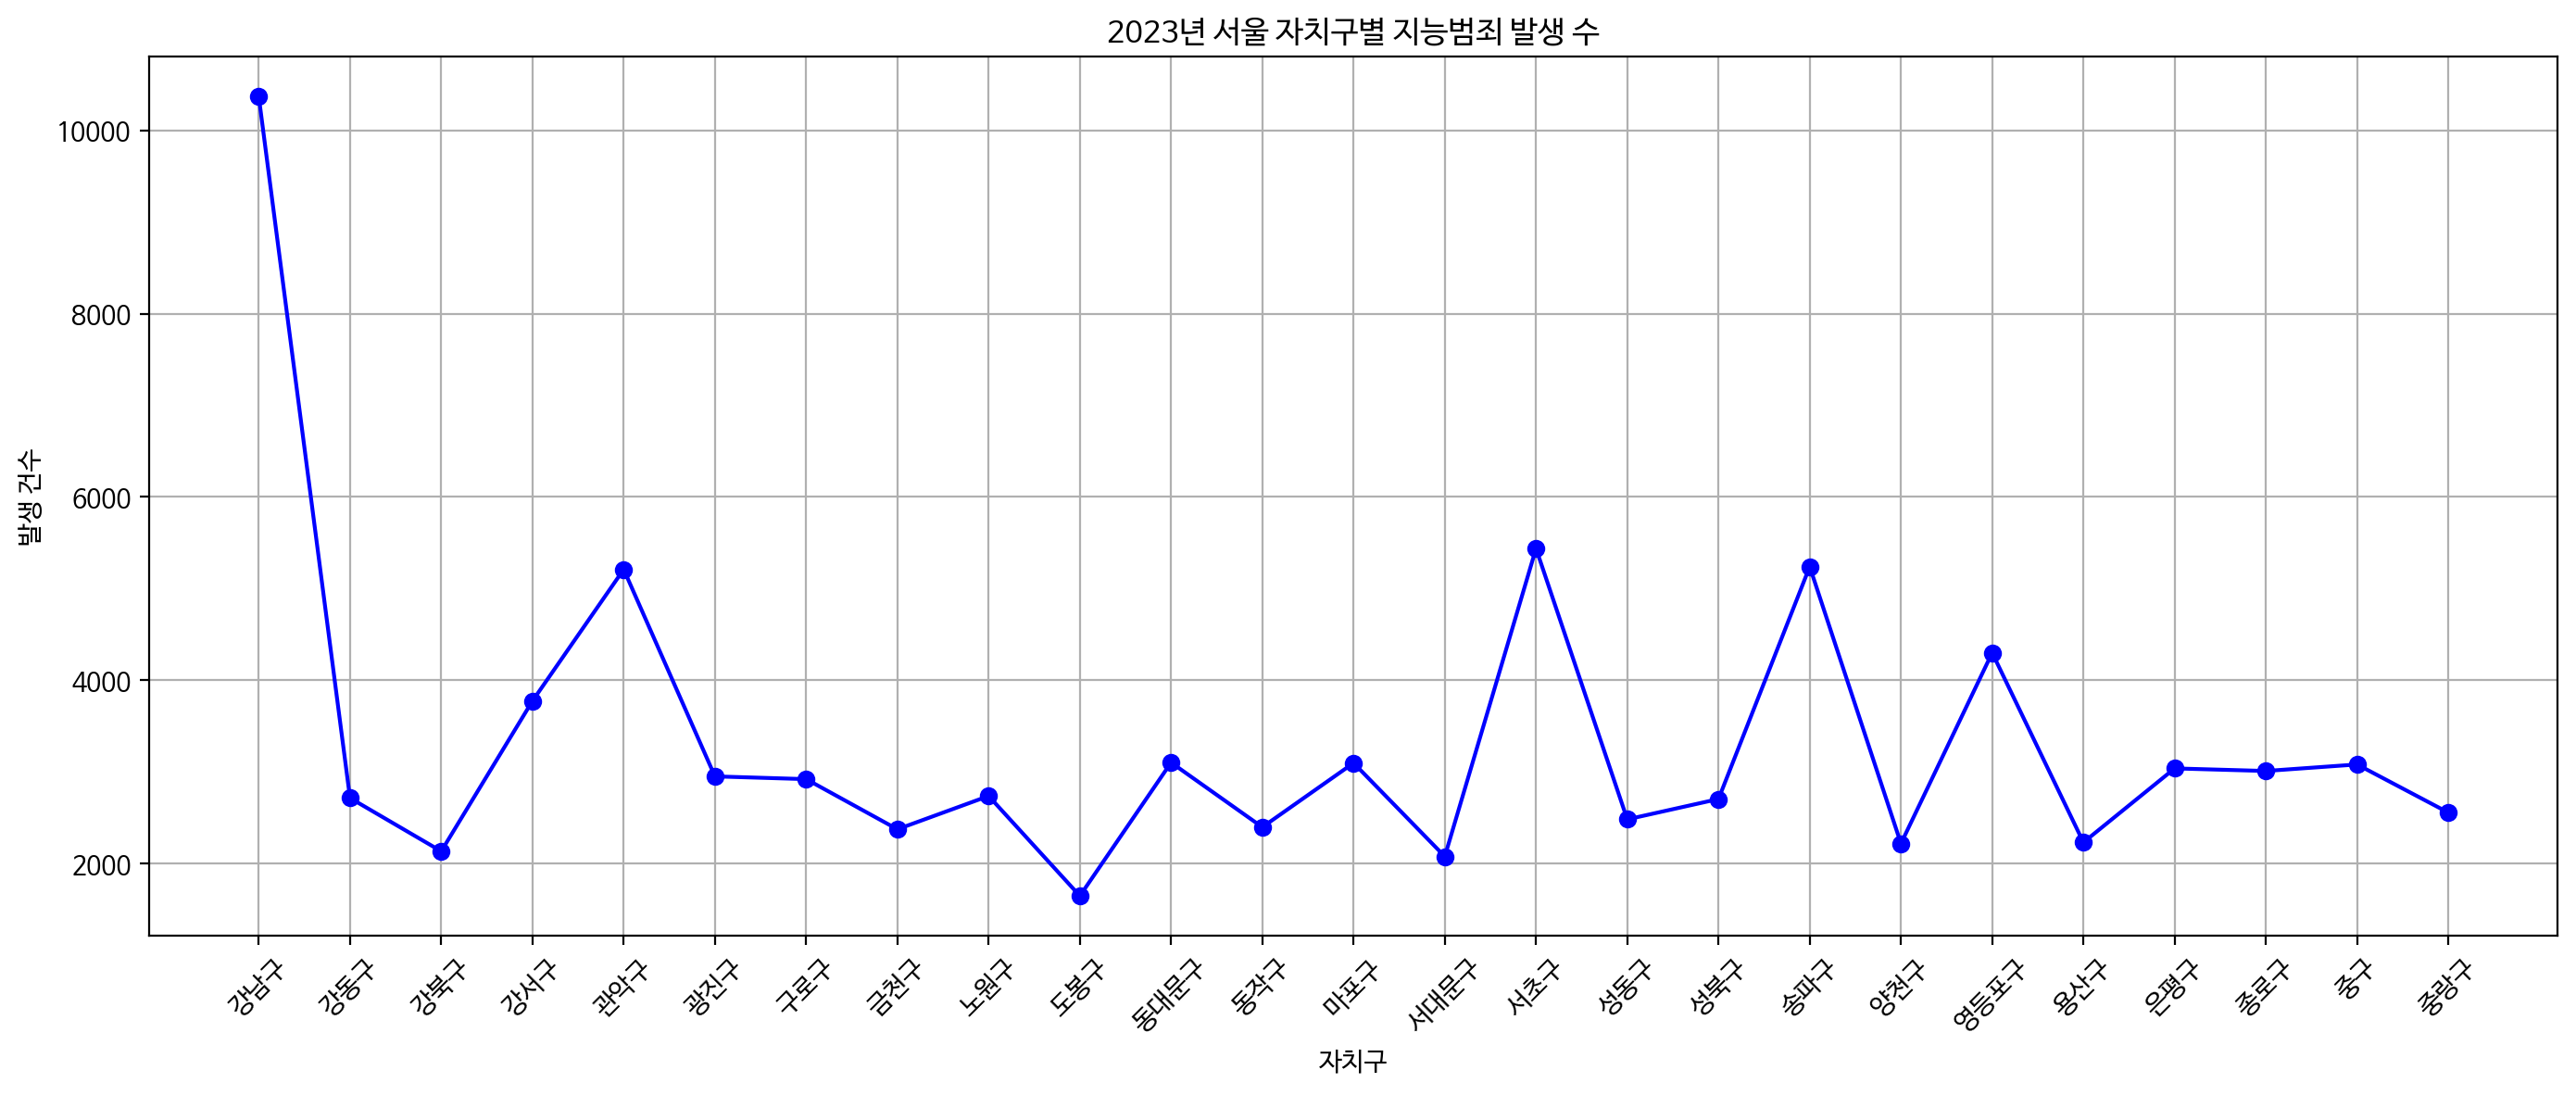

In [11]:
file_path = './2025-1-BigData-Team/CrimeData/범죄발생지역(2012~2023)/경찰청_범죄발생지_2023.csv'
df = pd.read_csv(file_path, encoding='cp949')

# 지능범죄 데이터 필터링
df = df[df['범죄대분류'] == '지능범죄']

# 서울 열만 추출
seoul_cols = [col for col in df.columns if col.startswith('서울')]

# 각 자치구별 지능범죄 발생 수 합 계산
seoul_data = df[seoul_cols].sum()

# '서울' 접두어 제거
seoul_data.index = [col.replace('서울', '') for col in seoul_data.index]

# 자치구 이름 가나다순 정렬
seoul_data = seoul_data.sort_index()

# 그래프
plt.figure(figsize=(14, 6))
plt.plot(seoul_data.index, seoul_data.values, marker='o', linestyle='-', color='blue')
plt.title('2023년 서울 자치구별 지능범죄 발생 수')
plt.xlabel('자치구')
plt.ylabel('발생 건수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 서울에서 지능범죄 발생 건수는 강남구가 압도적으로 높음.
# 뒤이어 관악, 서초, 송파구 등이 지능범죄 수가 많으며 금융, 상업지구 등의 밀도가 높은게 원인 일 확률 있음.

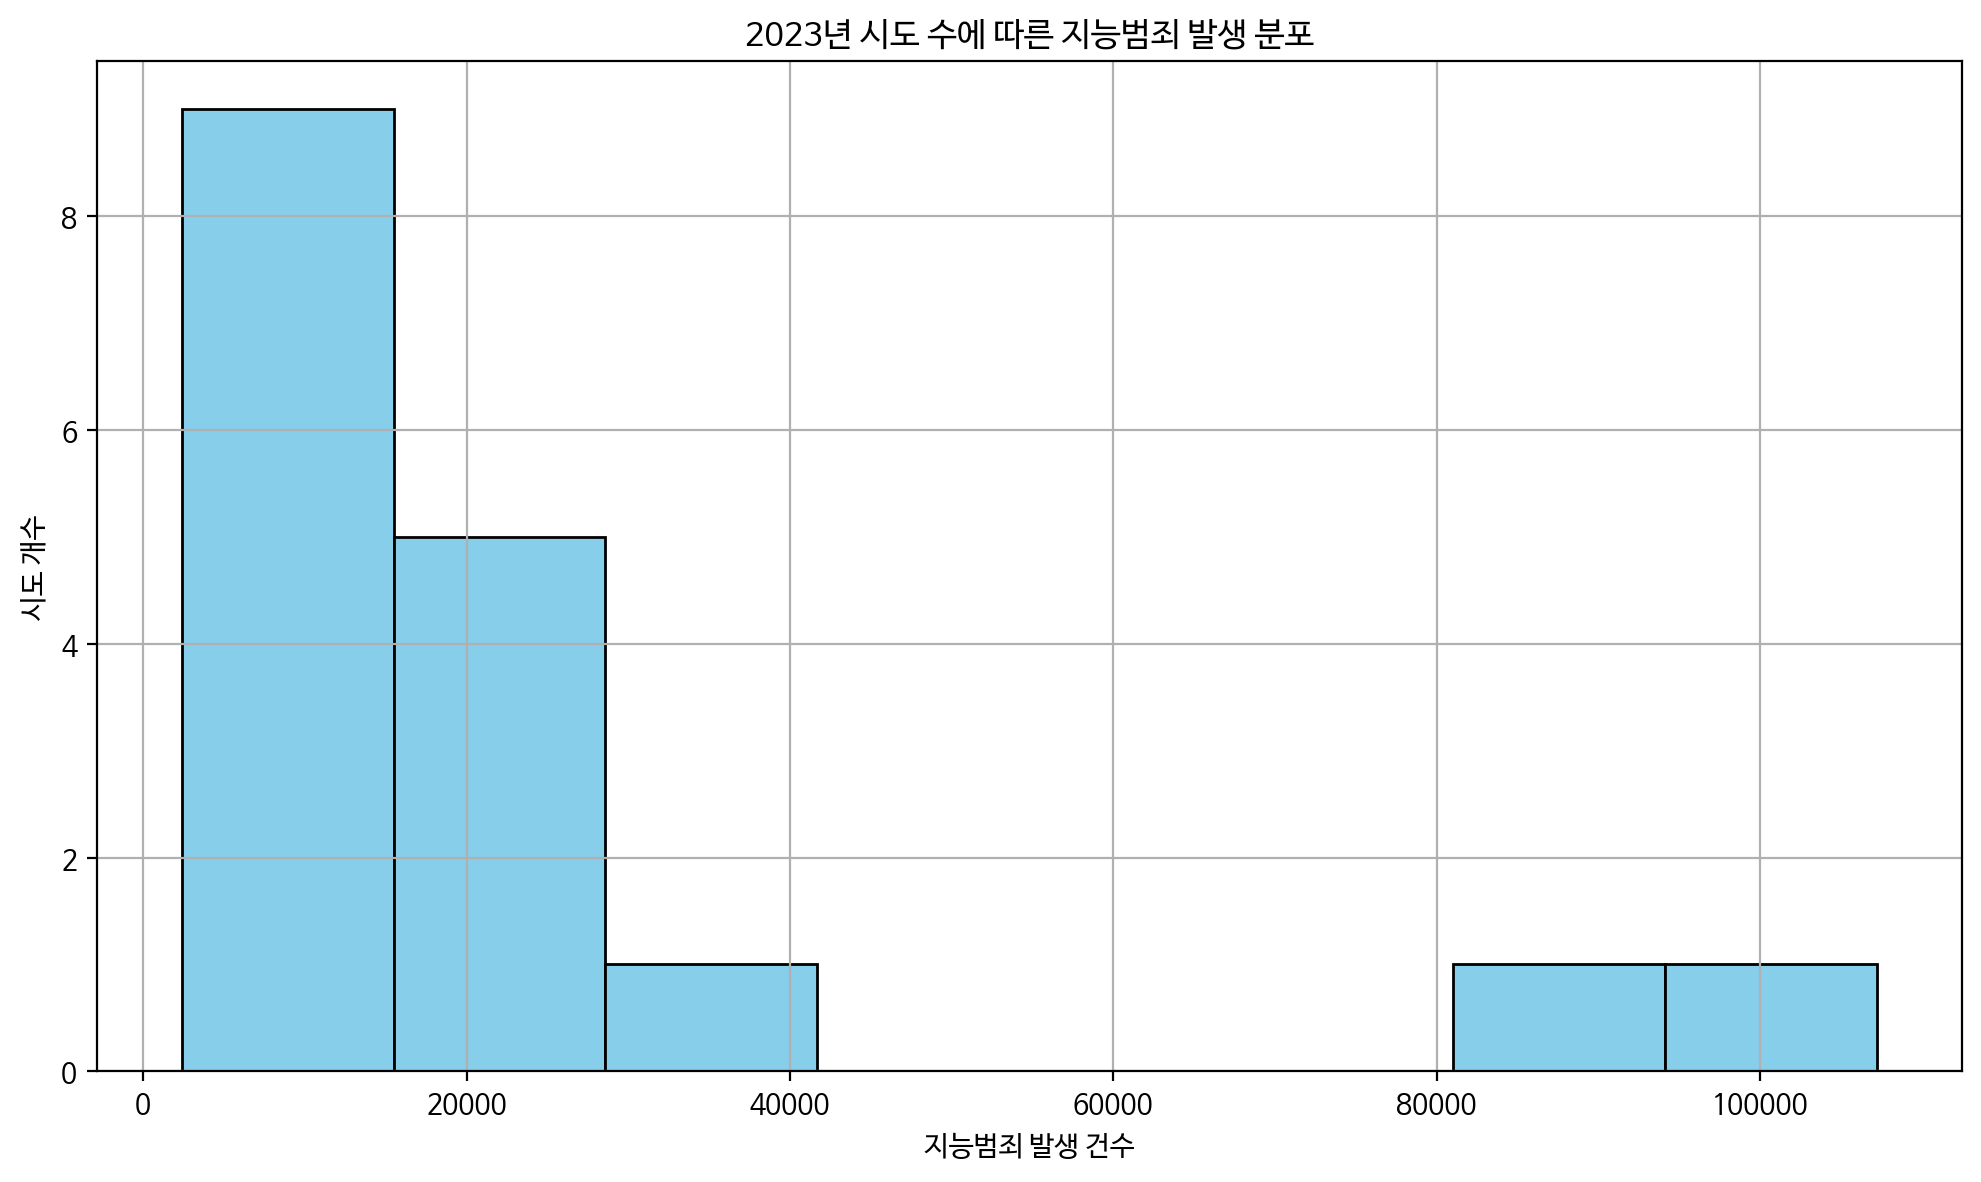

In [13]:
file_path = './2025-1-BigData-Team/CrimeData/범죄발생지역(2012~2023)/경찰청_범죄발생지_2023.csv'
df = pd.read_csv(file_path, encoding='cp949')

# 지능범죄 필터링
violent_df = df[df['범죄대분류'] == '지능범죄']

# 주요 시도 목록
main_provinces = ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종',
                  '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주']

# 지능범죄 발생 건수 합산
province_sums = {}
for prov in main_provinces:
    prov_cols = [col for col in violent_df.columns if col.startswith(prov)]
    if prov_cols:
        province_sums[prov] = violent_df[prov_cols].sum().sum()

# 그래프
plt.figure(figsize=(10, 6))
plt.hist(list(province_sums.values()), bins=8, color='skyblue', edgecolor='black')
plt.title('2023년 시도 수에 따른 지능범죄 발생 분포')
plt.xlabel('지능범죄 발생 건수')
plt.ylabel('시도 개수')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# 지능범죄 발생 건수가 상대적으로 낮은 시구가 많음.
# 지능범죄의 발생 건수가 유독 많은 시구는 수가 적음(수도권 집중).